<a href="https://colab.research.google.com/github/jlavilaj/MasterER/blob/main/CuadernosJupyter/SerieTemporalPolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skforecast
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 968.3/968.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.1 MB/s eta 0:00:00


Version skforecast: 0.19.1
Version Keras: 3.10.0
Using backend: tensorflow
Version pandas: 2.2.2
Version numpy: 2.0.2
Version tensorflow: 2.19.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [3]:
# Descarga y procesado de datos
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia_no_missing")
air_quality.head()

╭──────────────────────── air_quality_valencia_no_missing ─────────────────────────╮
│ Description:                                                                     │
│ Hourly measures of several air chemical pollutant at Valencia city (Avd.         │
│ Francia) from 2019-01-01 to 20213-12-31. Including the following variables:      │
│ pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),   │
│ O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have     │
│ been imputed using linear interpolation.                                         │
│                                                                                  │
│ Source:                                                                          │
│ Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València - │
│ Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-           │
│ historicos.                                                                      │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/air_quality_valencia_no_missing.csv                           │
│                                                                                  │
│ Shape: 43824 rows x 10 columns                                                   │
╰──────────────────────────────────────────────────────────────────────────────────╯

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [4]:
# Comprobación de índice y frecuencia
# ==============================================================================
print(f"Tipo de índice: {air_quality.index.dtype}")
print(f"Frecuencia: {air_quality.index.freq}")

Tipo de índice: datetime64[ns]
Frecuencia: <Hour>


In [5]:
# Split train-validation-test
# ==============================================================================
air_quality = air_quality.loc[:'2021-12-31 23:00:00', :].copy()
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Fechas validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Fechas test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fechas train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Fechas validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Fechas test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


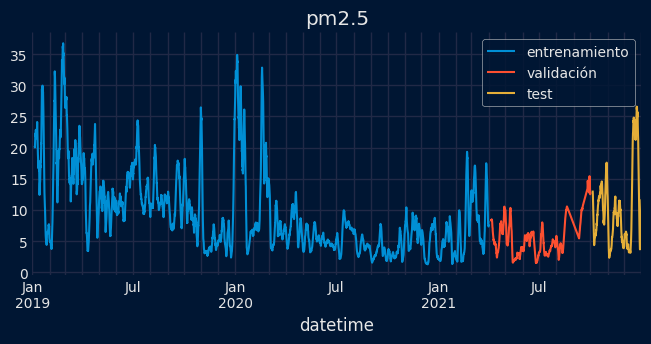

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [6]:
# Gráfico de la serie temporal del contaminante pm2.5
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="entrenamiento")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validación")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

In [18]:
# Creación del modelo
# ==============================================================================
series = ["no2","o3","co"]  # Series temporales que se utilizarán para entrenar el modelo.
levels = ["o3"]  # Serie que se quiere predecir
lags = 32        # Valores pasados a utilizar en la predicción
steps = 1        # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    # The optimizer and loss are typically handled by ForecasterRnn,
    # so they should not be passed to create_and_compile_model.
    # optimizer=Adam(learning_rate=0.01),
    # loss=MeanSquaredError()
)
model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    lags=lags,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,      # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
forecaster

/tmp/ipython-input-3640134351.py:3: FutureWarning:

The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 



============= 
ForecasterRnn 
============= 
Estimator: <Functional name=functional_1, built=True> 
Layers names: ['series_input', 'lstm_1', 'dense_1', 'output_dense_td_layer', 'reshape'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Window size: 32 
Maximum steps to predict: [1] 
Series names: None 
Target series (levels): ['o3'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 4, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 3]}, 'name': 'lstm_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 3), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 16, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4]}, 'name': 'dense_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4), 'dtype': 'float32', 'keras_history': ['lstm_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output_dense_td_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16]}, 'name': 'output_dense_td_layer', 'inbound_nodes'

In [20]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



615/615 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0604 - val_loss: 0.0146
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0048 - val_loss: 0.0050


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [21]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()
predictions

/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,level,pred
2021-04-01,o3,45.679768


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [22]:
# Backtesting con datos de test
# ==============================================================================
cv = TimeSeriesFold(
    steps=forecaster.max_step,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 6/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 10/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0047 - val_loss: 0.0046


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



  0%|          | 0/2208 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWa

In [23]:
predictions

,level,fold,pred
2021-10-01 00:00:00,o3,0,53.124123
2021-10-01 01:00:00,o3,1,56.377331
2021-10-01 02:00:00,o3,2,60.205025
2021-10-01 03:00:00,o3,3,61.297718
2021-10-01 04:00:00,o3,4,52.242214
...,...,...,...
2021-12-31 19:00:00,o3,2203,16.836376
2021-12-31 20:00:00,o3,2204,14.288136
2021-12-31 21:00:00,o3,2205,16.258154
2021-12-31 22:00:00,o3,2206,16.625505


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



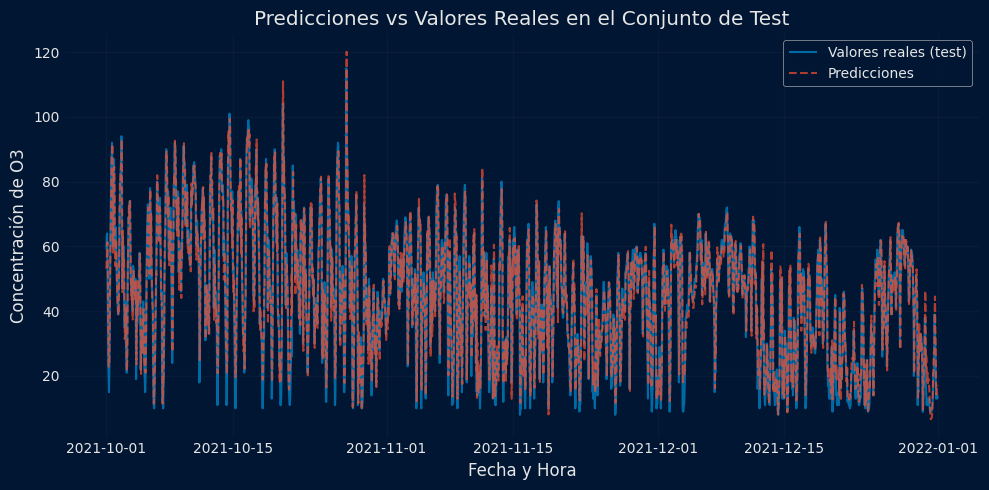

In [26]:

plt.figure(figsize=(10, 5))


plt.plot(data_test.index, data_test['o3'], label='Valores reales (test)', linestyle='-', alpha=0.7)

# Graficar las predicciones
plt.plot(predictions.index, predictions['pred'], label='Predicciones', linestyle='--', alpha=0.7)


plt.title("Predicciones vs Valores Reales en el Conjunto de Test")
plt.xlabel("Fecha y Hora")
plt.ylabel("Concentración de O3")
plt.legend()
plt.grid(alpha=0.3)


plt.tight_layout()
plt.show()

In [ ]:
metrics

In [27]:


# Error en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error (mae) relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 10.51 %
